# BentoML Example: Keras Fashion MNIST

[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. 

This notebook demonstrates how to use BentoML to turn a Keras model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=keras&ea=keras-fashion-mnist&dt=keras-fashion-mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install bentoml
!pip install tensorflow numpy matplotlib

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
print("Tensorflow Version: %s" % tf.__version__)

import bentoml
print("BentoML Version: %s" % bentoml.__version__)

Tensorflow Version: 1.13.1
BentoML Version: 0.4.1


## Load Fashion MNIST dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

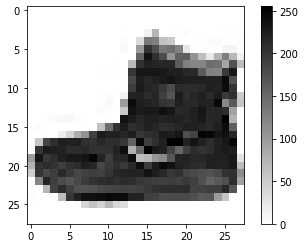

In [5]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

We should scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

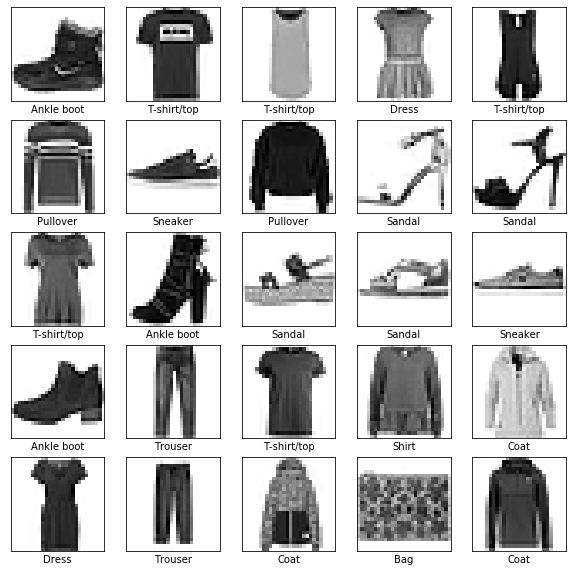

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [8]:
# Reshaping the images so that our model can accept it
train_images  = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

## Build the model

In [9]:
model = keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)  

## Compile the model

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

In [11]:
model.fit(train_images, train_labels, batch_size=64, epochs=1)

60000/60000 [==============================] - 53s 886us/sample - loss: 0.5916 - acc: 0.7819


## Evaluate model accuracy

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 134us/sample - loss: 0.3885 - acc: 0.8604
Test accuracy: 0.8604


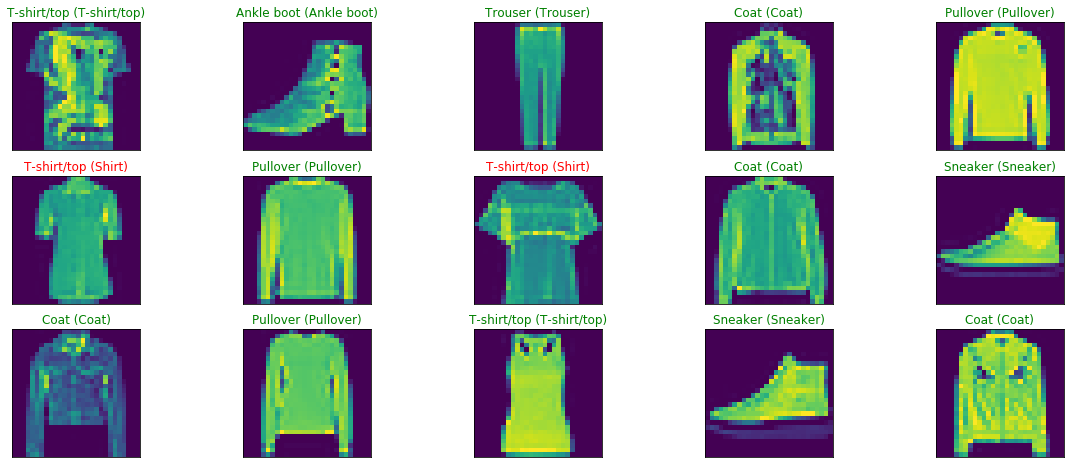

In [13]:
y_hat = model.predict_classes(test_images)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = y_hat[index]
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Predict on a single image

Let's first see the test image and and its label:

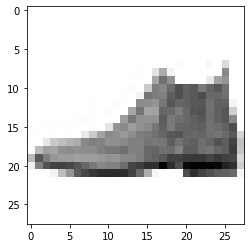

Class: Ankle boot


In [14]:
plt.imshow(test_images[0].squeeze(-1), cmap=plt.cm.binary)
plt.show()
print('Class:', class_names[test_labels[0]])

In [15]:
pred_idx = model.predict_classes(np.expand_dims(test_images[0], 0))[0]
print('Prediction:', class_names[pred_idx])

Prediction: Ankle boot


## Define BentoService for model serving

In [16]:
%%writefile keras_fashion_mnist.py

import numpy as np
from PIL import Image
from bentoml import api, artifacts, env, BentoService
from bentoml.artifact import KerasModelArtifact
from bentoml.handlers import ImageHandler

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

@env(pip_dependencies=['tensorflow==1.13.1', 'Pillow', 'numpy'])
@artifacts([KerasModelArtifact('classifier')])
class KerasFashionMnistService(BentoService):
        
    @api(ImageHandler, pilmode='L')
    def predict(self, img):
        img = Image.fromarray(img).resize((28, 28))
        img /= 255.0
        img = np.array(img.getdata()).reshape((1,28,28,1))
        class_idx = self.artifacts.classifier.predict_classes(img)[0]
        return class_names[class_idx]

Overwriting keras_fashion_mnist.py


## Save BentoService to file archive

In [17]:
# 1) import the custom BentoService defined above
from keras_fashion_mnist import KerasFashionMnistService

# 2) `pack` it with required artifacts
mnist_svc = KerasFashionMnistService.pack(classifier=model)

# 3) save your BentoSerivce to file archive
saved_path = mnist_svc.save()

[2019-09-19 14:54:27,537] INFO - Successfully saved Bento 'KerasFashionMnistService:2019_09_19_c89a17b6' to path: /Users/chaoyuyang/bentoml/repository/KerasFashionMnistService/2019_09_19_c89a17b6


## Load BentoService from archive


In [18]:
svc = bentoml.load(saved_path)

svc.predict(test_images[0].squeeze(-1))

[2019-09-19 14:56:42,654] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.


'Ankle boot'

# "pip install" a BentoService archive

BentoML user can directly pip install saved BentoML archive with `pip install $SAVED_PATH`,  and use it as a regular python package.

In [19]:
!pip install {saved_path}

Processing /Users/chaoyuyang/bentoml/repository/KerasFashionMnistService/2019_09_19_c89a17b6
  Stored in directory: /private/var/folders/ns/vc9qhmqx5dx_9fws7d869lqh0000gn/T/pip-ephem-wheel-cache-48rdtolw/wheels/3a/5b/25/f9bc6682169491c8c9bfbef9c95b065f63c9b28f73088d6b84
Successfully built KerasFashionMnistService
  Found existing installation: KerasFashionMnistService 2019-09-17-6bf40ee7
    Uninstalling KerasFashionMnistService-2019-09-17-6bf40ee7:
      Successfully uninstalled KerasFashionMnistService-2019-09-17-6bf40ee7


In [20]:
# Your bentoML model class name will become packaged name
import KerasFashionMnistService

ms = KerasFashionMnistService.load()
ms.predict(test_images[0].squeeze(-1))

[2019-09-19 14:56:49,989] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.
[2019-09-19 14:56:50,184] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.


'Ankle boot'

the installed pip package also comes with a CLI tool:

In [21]:
!KerasFashionMnistService predict --input=sample_image.png

2019-09-19 14:56:55.411868: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Ankle boot


# Model Serving via REST API

In your termnial, run the following command to start the REST API server:

In [22]:
!bentoml serve {saved_path}

2019-09-19 14:56:59.508895: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
 * Serving Flask app "KerasFashionMnistService" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Sep/2019 14:57:02] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Sep/2019 14:57:02] "GET /docs.json HTTP/1.1" 200 -
127.0.0.1 - - [19/Sep/2019 14:57:03] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [19/Sep/2019 14:57:11] "POST /predict HTTP/1.1" 200 -
^C


Test sending request to API Server from terminal:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

or:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

## Containerize REST API server with Docker

** _Make sure you have `docker` installed, note that it is not available when running in Google Colaboratory_

In [23]:
!cd {saved_path} && docker build -t keras-fashion-mnist .

Sending build context to Docker daemon  5.015MB
Step 1/11 : FROM continuumio/miniconda3
 ---> ae46c364060f
Step 2/11 : ENTRYPOINT [ "/bin/bash", "-c" ]
 ---> Using cache
 ---> 2f135ada8e2d
Step 3/11 : EXPOSE 5000
 ---> Using cache
 ---> 738f652d09ae
Step 4/11 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 70c62a45013a
Step 5/11 : RUN conda update conda -y       && conda install pip numpy scipy       && pip install gunicorn six
 ---> Using cache
 ---> fe5d966ecc35
Step 6/11 : COPY . /bento
 ---> bfc64195d40e
Step 7/11 : WORKDIR /bento
 ---> Running in 90b2de30b3e3
Removing intermediate container 90b2de30b3e3
 ---> 79668be41605
Step 8/11 : RUN conda env update -n base -f /bento/environment.yml
 ---> Running in 1fb43da624cf
Solving environment: ...working... 
The environment is inconsistent, please check the package plan carefully
The followin

Removing intermediate container 1fb43da624cf
 ---> 3ed901c69b13
Step 9/11 : RUN pip install -r /bento/requirements.txt
 ---> Running in 3348b2b5f423


  Created wheel for termcolor: filename=termcolor-1.1.0-cp37-none-any.whl size=4831 sha256=c8c2a06235de5e59aa8f75c1a53b9d5d0590eec0f8ea87fd18dded622a1be5a0
  Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Created wheel for absl-py: filename=absl_py-0.8.0-cp37-none-any.whl size=120986 sha256=60c184b6c08827dbb0ce342c33377ba885b9dd548decc324681c6e15e71dd87d
  Stored in directory: /root/.cache/pip/wheels/9a/1e/7a/456008eb5e47fd5de792c6139df6d5b3d5f71d51c6a0b94799
  Created wheel for gast: filename=gast-0.3.2-cp37-none-any.whl size=9678 sha256=fce2bb44ef4e04b510628c5881f46c6c9ad458438ad4c1ea8e4301a52f7e10dc
  Stored in directory: /root/.cache/pip/wheels/59/38/c6/234dc39b4f6951a0768fbc02d5b7207137a5b1d9094f0d54bf
Successfully built termcolor absl-py gast
Removing intermediate container 3348b2b5f423
 ---> 2aa3f3aff785
Step 10/11 : RUN if [ -f /bento/setup.sh ]; then /bin/bash -c /bento/setup.sh; fi
 ---> Running in 0b0b99e48eee
Remov

In [26]:
!docker run -p 5000:5000 keras-fashion-mnist

[2019-09-19 22:10:43 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2019-09-19 22:10:43 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2019-09-19 22:10:43 +0000] [1] [INFO] Using worker: sync
[2019-09-19 22:10:43 +0000] [9] [INFO] Booting worker with pid: 9
[2019-09-19 22:10:43 +0000] [10] [INFO] Booting worker with pid: 10
[2019-09-19 22:10:43 +0000] [11] [INFO] Booting worker with pid: 11
2019-09-19 22:10:43.538372: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-09-19 22:10:43.549662: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2904000000 Hz
2019-09-19 22:10:43.550454: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55c09b8afea0 executing computations on platform Host. Devices:
2019-09-19 22:10:43.550517: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-09-19 22:10:43.552